In [1]:
import pickle
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import particle_evolution
import feo_thermodynamics as feot
import multiprocessing
import bulk_case_runner

# We have some annoying warnings - I think from llvm bug - fix then remove this
import warnings
warnings.filterwarnings("ignore")

In [2]:
base_parameters = {'f_layer_thickness': 200.0E3,
                    'delta_t_icb': 10.0,
                    'xfe_outer_core': 0.92,
                    'xfe_icb': 0.92,
                    'growth_prefactor': 150.0,
                    'chemical_diffusivity': 1.0E-9,
                    'kinematic_viscosity': 1.0E-6,
                    'i0': 1.0E-10,
                    'surf_energy': 1.08E-2, 
                    'number_of_analysis_points': 200,
                    'r_icb': 1221.5E3, 
                    'r_cmb': 3480.0E3,
                    'gruneisen_parameter': 1.5}

# Just runs in serial
data = bulk_case_runner.run_flayer_case(base_parameters, "cases/base_case.pickle")
print("Done, inner core growth rate is", data["growth_rate"], "km/Myr")
print("Max vf_ratio is", data["vf_ratio"].max())


Done, inner core growth rate is 16.15632934419563 km/Myr
Max vf_ratio is 9.820868684020741e-05


In [3]:
# Bunch of cases, four at a time

cases = []

for dl in [5.0E-8, 1.0E-8, 5.0E-9, 5.0E-10, 1.0E-10, 5.0E-11]:
    name = f"cases/{dl:.3e}_dl_case"
    input_parameters = dict(base_parameters)
    input_parameters["chemical_diffusivity"] = dl
    cases.append((name, input_parameters))
    
for i0 in [1.0E-8, 1.0E-9, 1.0E-11, 1.0E-12]:
    name = f"cases/{i0:.3e}_i0_case"
    input_parameters = dict(base_parameters)
    input_parameters["i0"] = i0
    cases.append((name, input_parameters)) 

for gamma in [1.08, 1.08E-1, 1.08E-3, 1.08E-4]:
    name = f"cases/{gamma:.3e}_gamma_case"
    input_parameters = dict(base_parameters)
    input_parameters["i0"] = gamma
    cases.append((name, input_parameters))
    
for mu in [1.0E-4, 1.0E-5, 1.0E-7, 1.0E-8]:
    name = f"cases/{mu:.3e}_mu_case"
    input_parameters = dict(base_parameters)
    input_parameters["kinematic_viscosity"] = mu
    cases.append((name, input_parameters))   
    
for k0 in [10.0, 50.0, 100.0, 200.0]:
    name = f"cases/{k0:.3e}_k0_case"
    input_parameters = dict(base_parameters)
    input_parameters["growth_prefactor"] = k0
    cases.append((name, input_parameters))
    
with multiprocessing.Pool(processes=4) as pool:
    pool.map(bulk_case_runner.case_handler, cases)

cases/1.000e-08_i0_case: growth rate 1491.8047512419712 km/Myrm ax vf_ratio 0.009132141225649447
cases/1.000e-09_i0_case: growth rate 160.6650649809941 km/Myrm ax vf_ratio 0.00097872904013499
cases/1.080e-03_gamma_case: growth rate 0.0010458504623505843 km/Myrm ax vf_ratio 0.018480194022630247
cases/1.080e-04_gamma_case: growth rate 0.00010469793216320427 km/Myrm ax vf_ratio 0.02395276615200848
cases/1.000e+01_k0_case: growth rate 16.14436218663707 km/Myrm ax vf_ratio 9.814677391774889e-05
cases/5.000e+01_k0_case: growth rate 16.141658588695144 km/Myrm ax vf_ratio 9.812811112784867e-05
cases/1.000e-10_dl_case: growth rate 0.3868062019987663 km/Myrm ax vf_ratio 4.807150195448184e-06
cases/5.000e-11_dl_case: growth rate 0.13410629534648366 km/Myrm ax vf_ratio 2.1941504061743172e-06
cases/1.000e-11_i0_case: growth rate 1.6164055900728378 km/Myrm ax vf_ratio 9.493959105998107e-06
cases/1.000e-12_i0_case: growth rate 0.16178974800154078 km/Myrm ax vf_ratio 7.718854039511675e-07
cases/1.000e

Temperature at CMB is 4091.0000127665962 K
Temberature at top of F-layer is 5495.375594101565 K
Temberature at ICB is 5560.445773134292 K


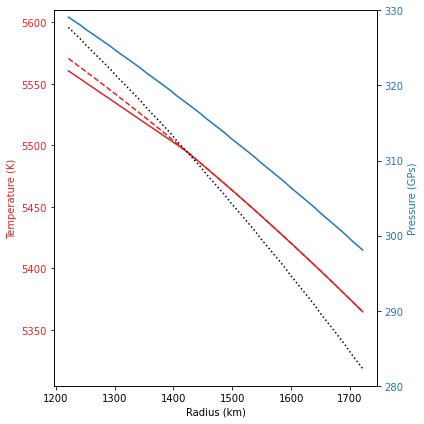

cases/1.000e-04_mu_case.pickle
growth rate 3.3555507640312427 km/Myr max vf_ratio 9.314580044600718e-05
Particle radii between 0.0147 and 2.86e-05 m


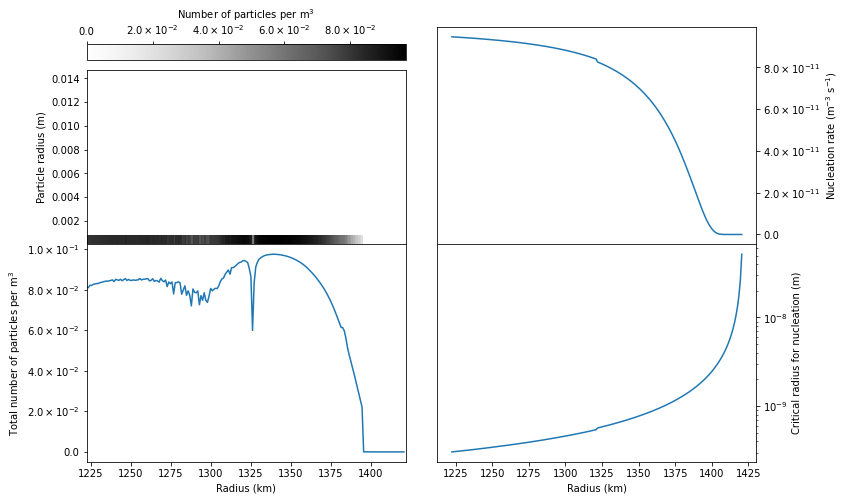

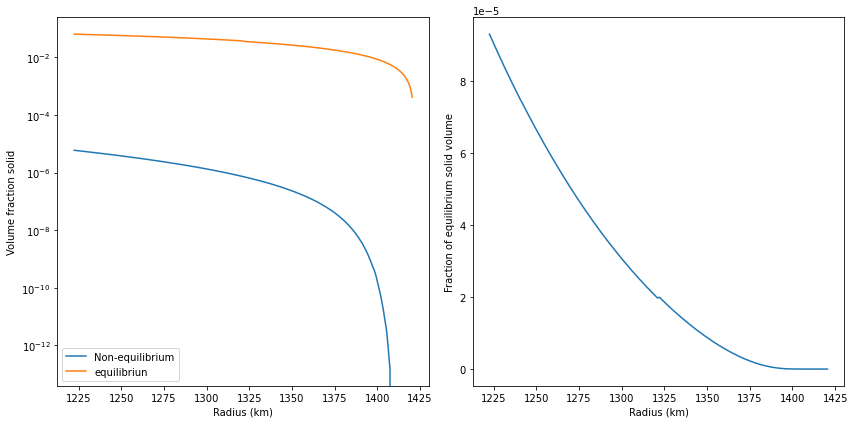

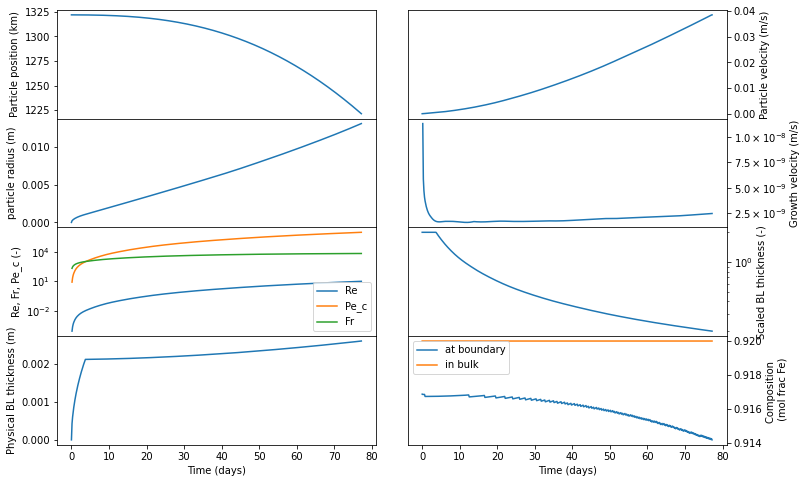


cases/1.000e-11_i0_case.pickle
growth rate 1.6164055900728378 km/Myr max vf_ratio 9.493959105998107e-06
Particle radii between 0.0266 and 9.07e-06 m


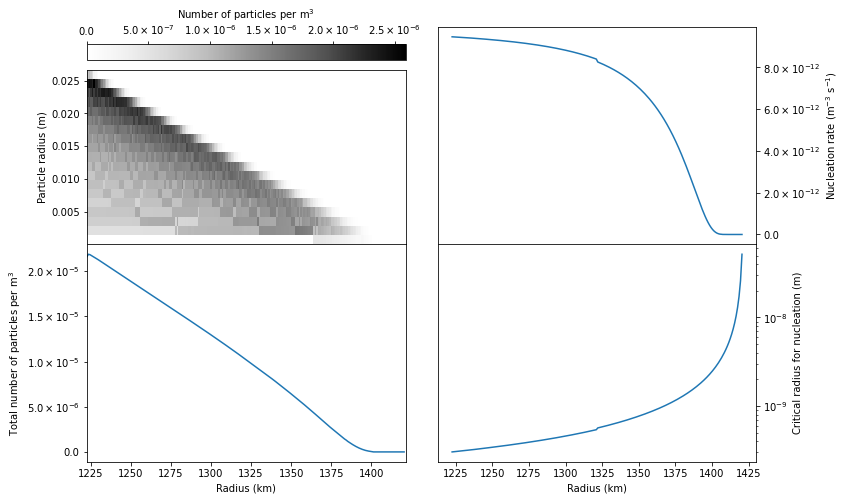

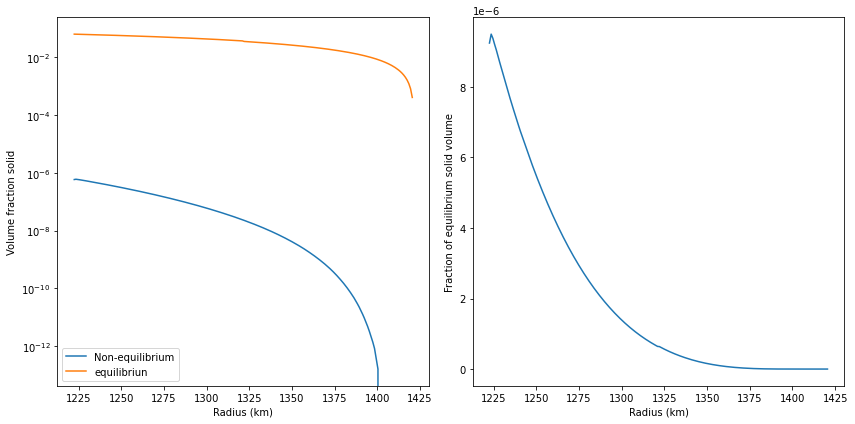

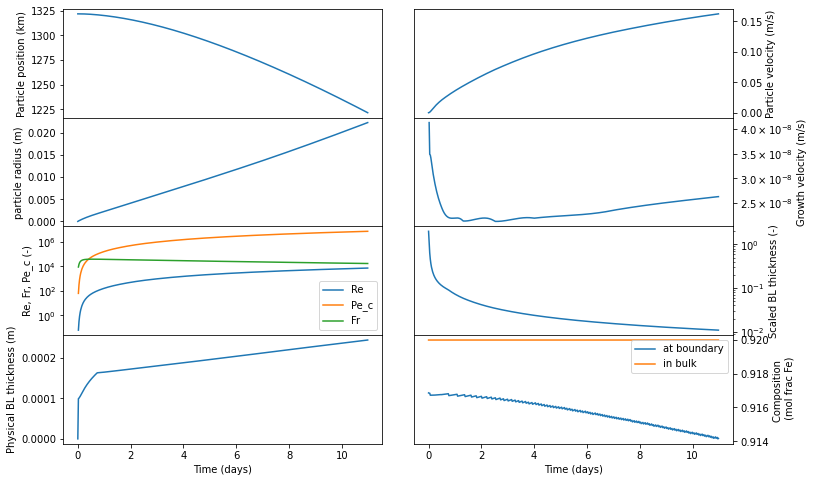


cases/5.000e+01_k0_case.pickle
growth rate 16.141658588695144 km/Myr max vf_ratio 9.812811112784867e-05
Particle radii between 0.0265 and 9.07e-06 m


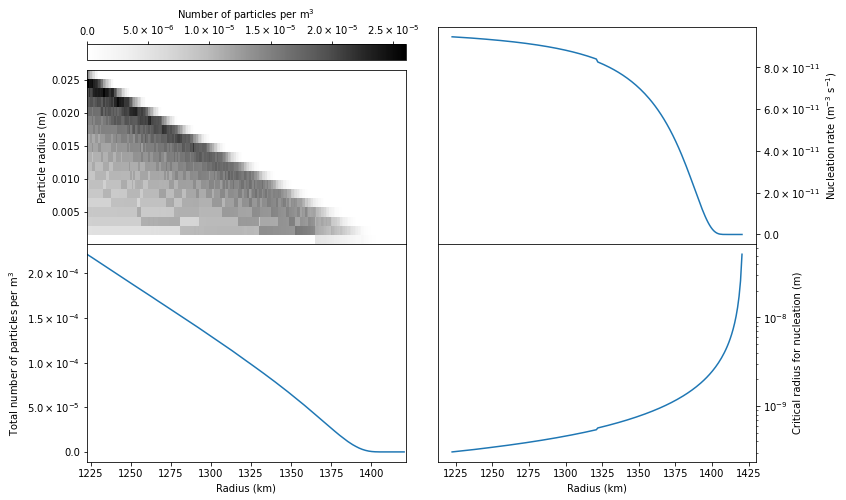

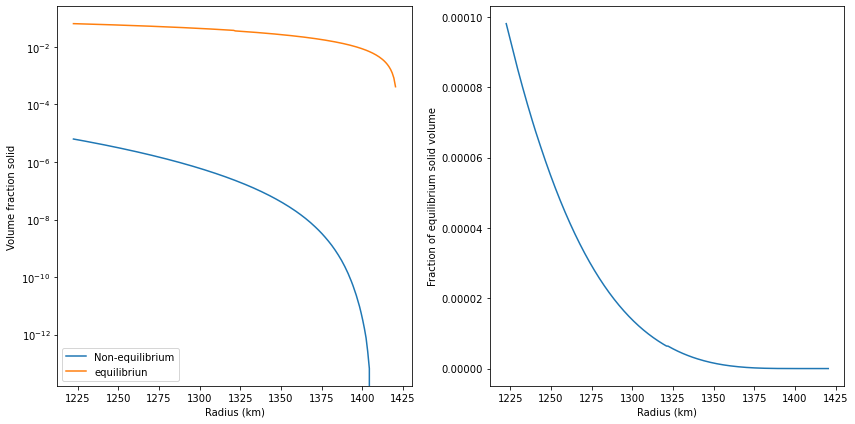

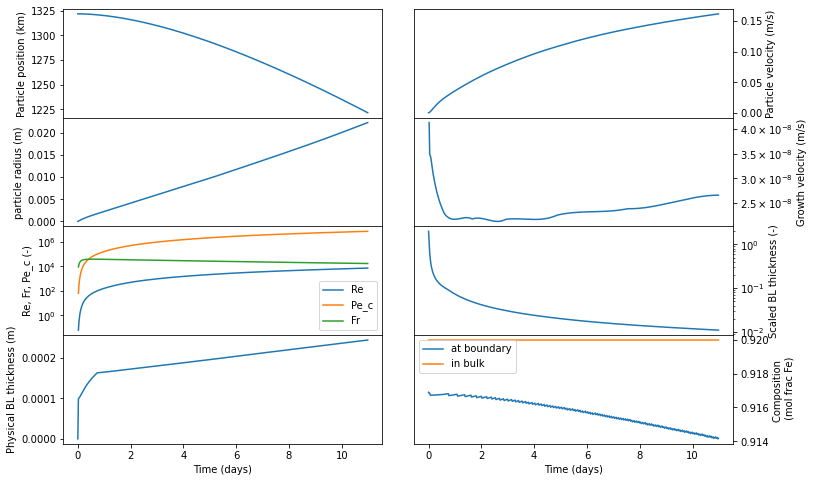


cases/1.000e+01_k0_case.pickle
growth rate 16.14436218663707 km/Myr max vf_ratio 9.814677391774889e-05
Particle radii between 0.0266 and 9.07e-06 m


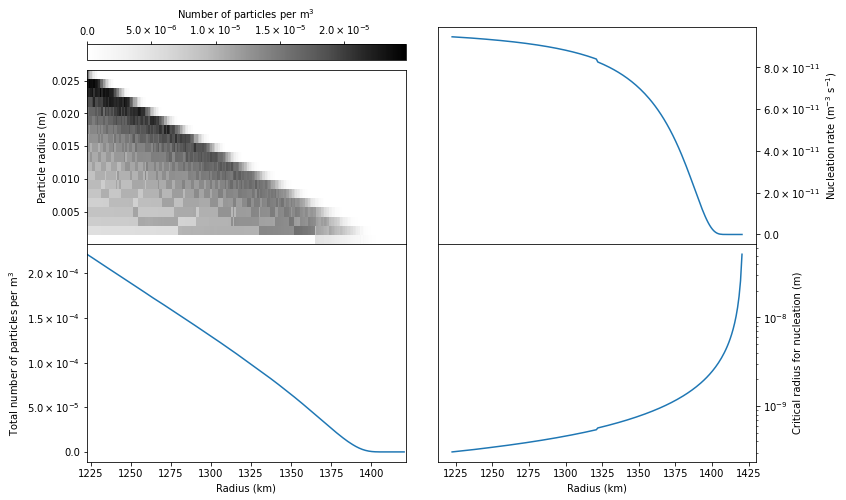

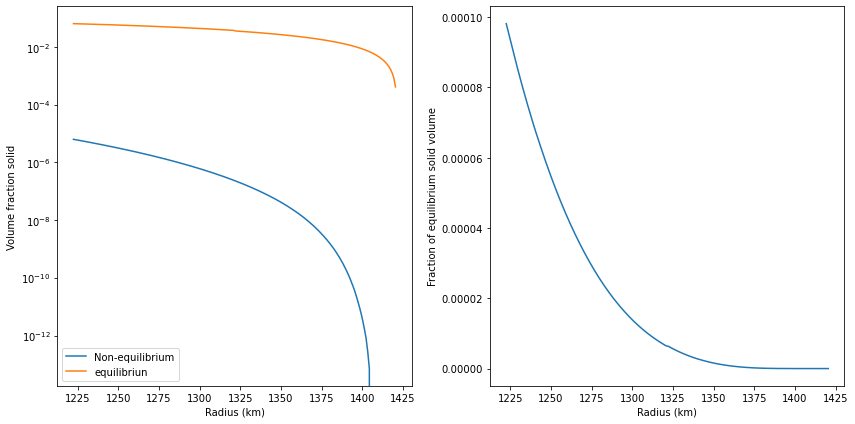

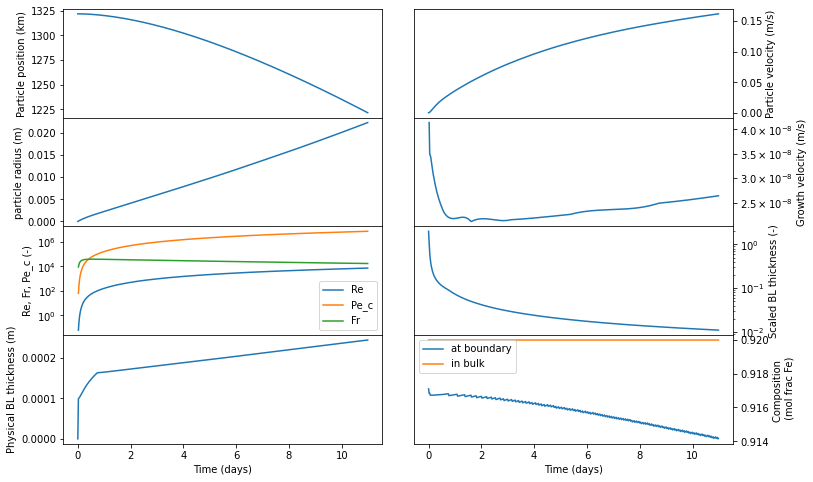


cases/1.000e-05_mu_case.pickle
growth rate 3.8933639349310702 km/Myr max vf_ratio 4.1962677669833934e-05
Particle radii between 0.016 and 1.61e-05 m


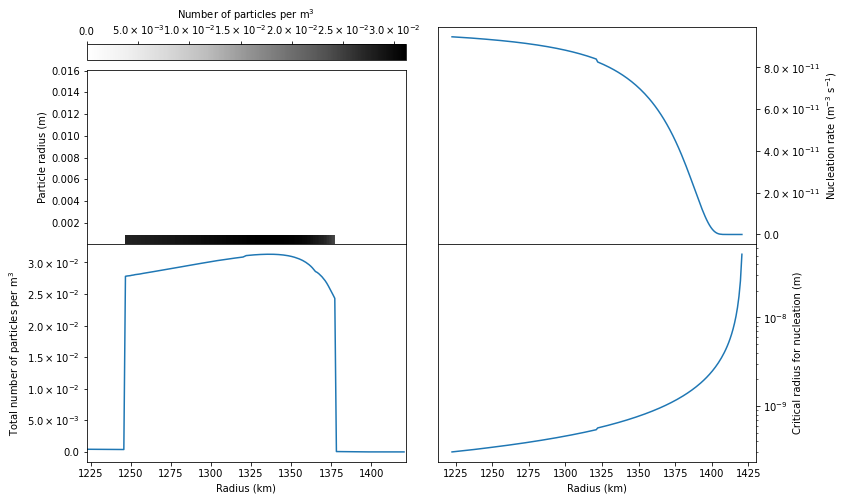

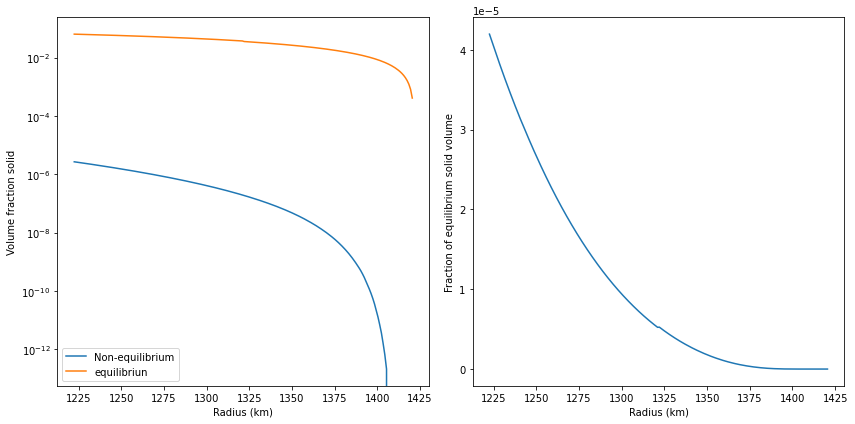

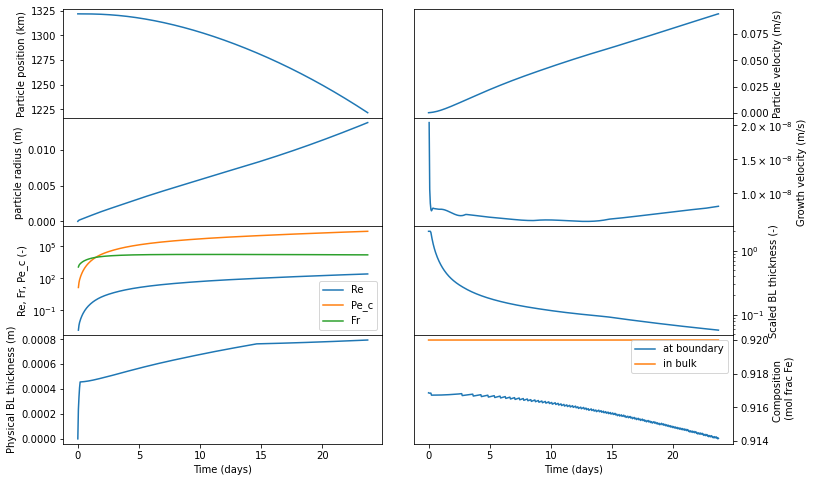


cases/1.000e-12_i0_case.pickle
growth rate 0.16178974800154078 km/Myr max vf_ratio 7.718854039511675e-07
Particle radii between 0.0265 and 9.07e-06 m


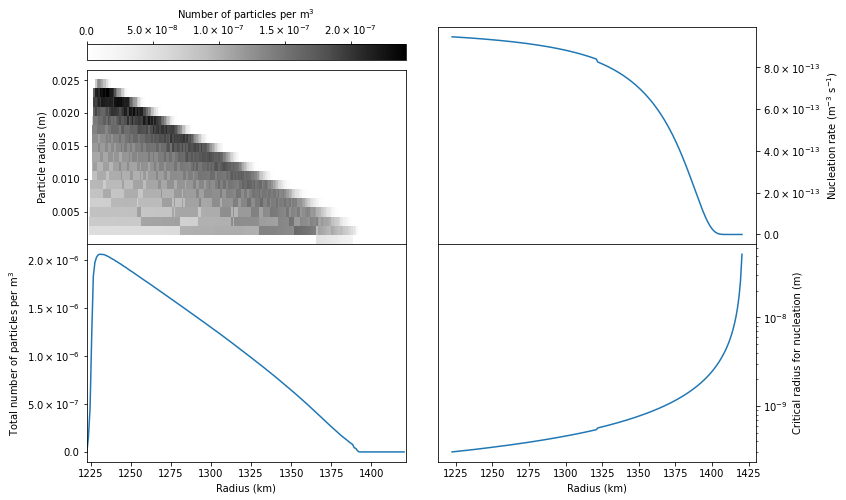

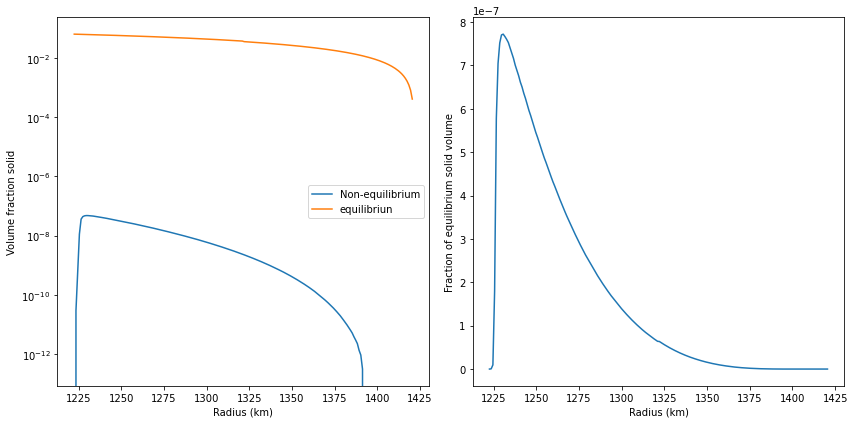

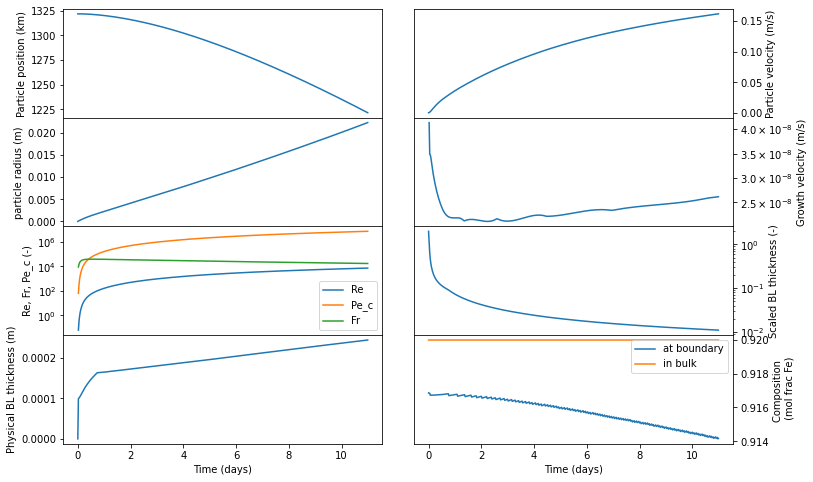


cases/1.000e-07_mu_case.pickle
growth rate 122.7987491703287 km/Myr max vf_ratio 0.0005859404345030662
Particle radii between 0.0524 and 5.11e-06 m


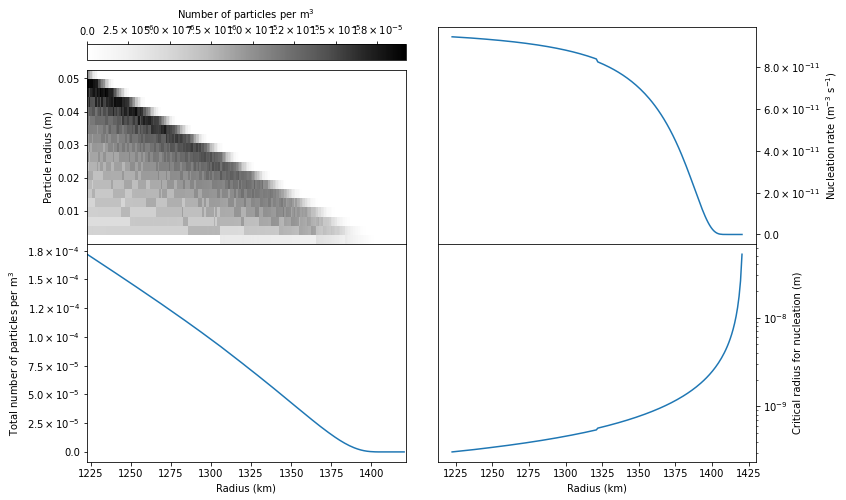

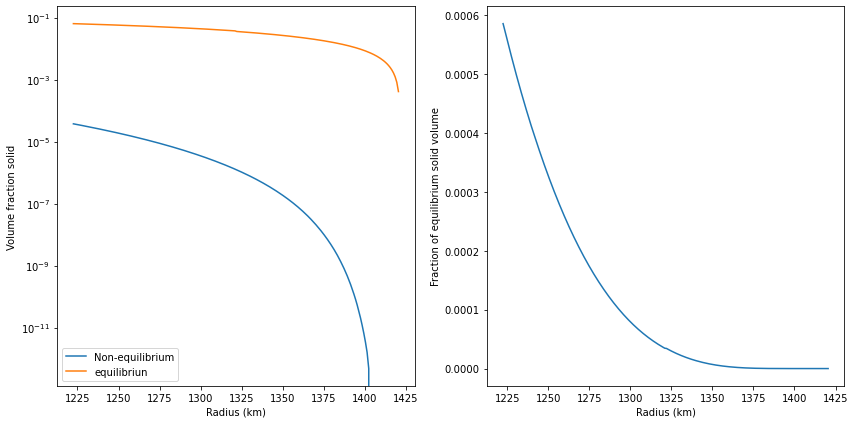

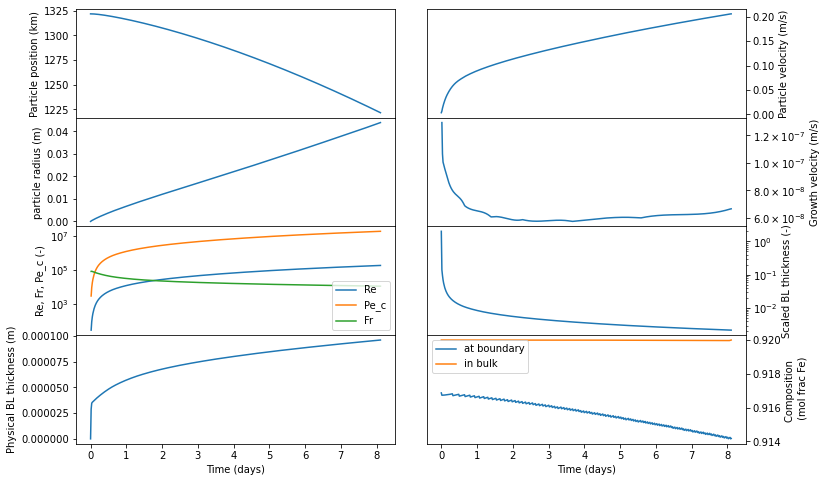


cases/2.000e+02_k0_case.pickle
growth rate 16.154441884930144 km/Myr max vf_ratio 9.819889204484657e-05
Particle radii between 0.0265 and 9.07e-06 m


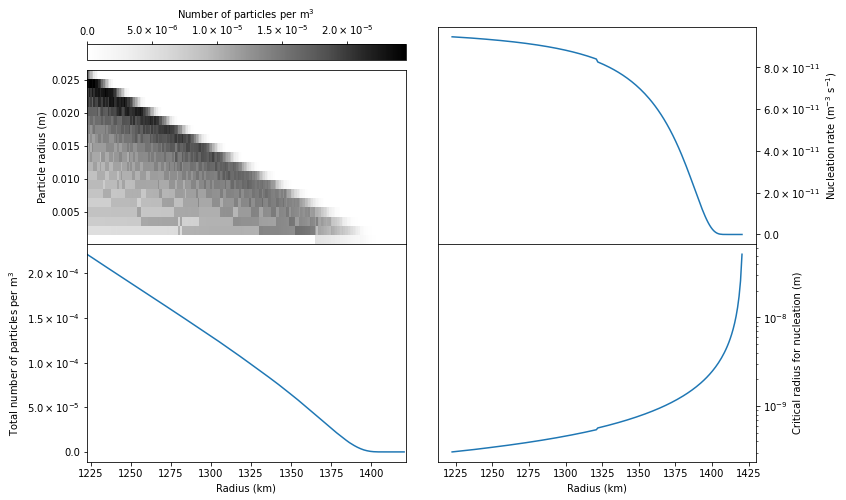

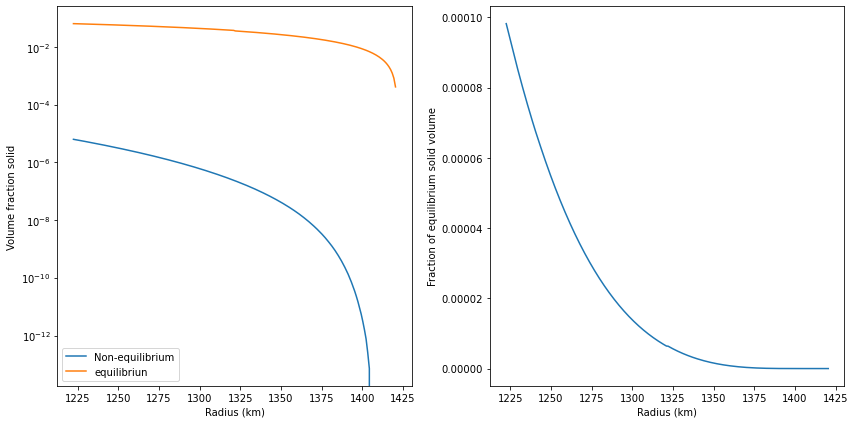

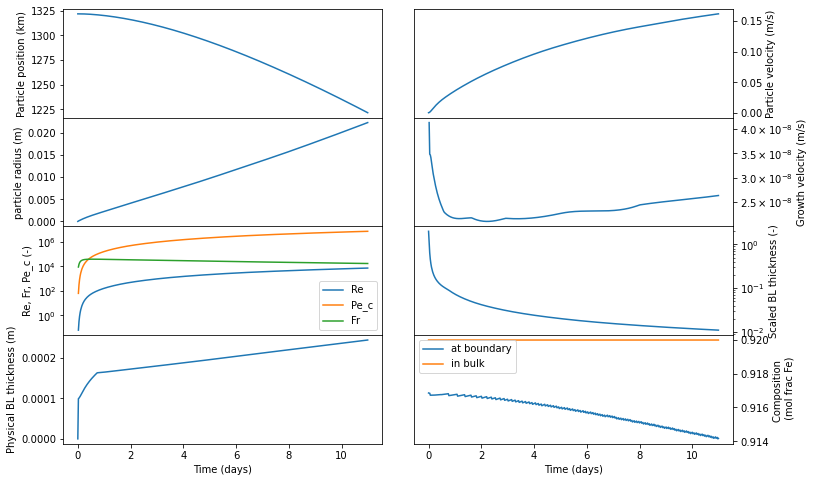


cases/1.000e-08_mu_case.pickle
growth rate 848.1249943481123 km/Myr max vf_ratio 0.002810939270114643
Particle radii between 0.101 and 2.96e-06 m


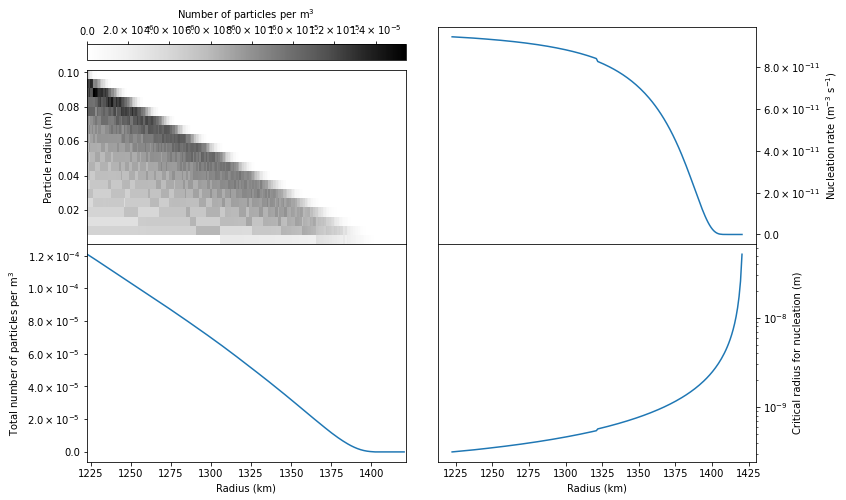

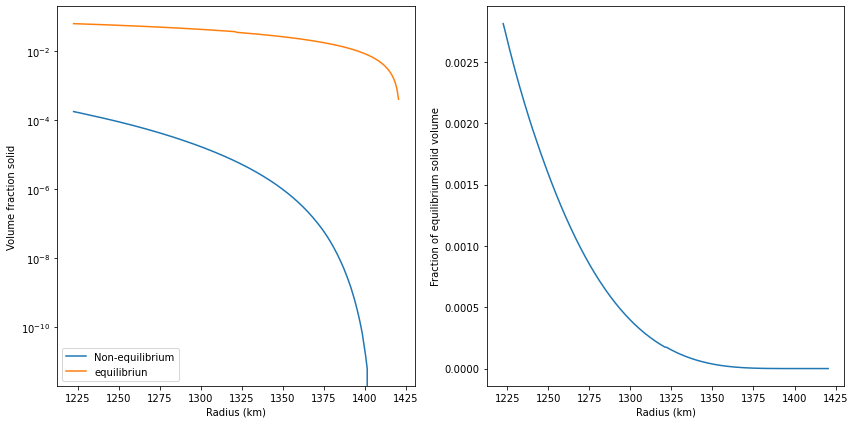

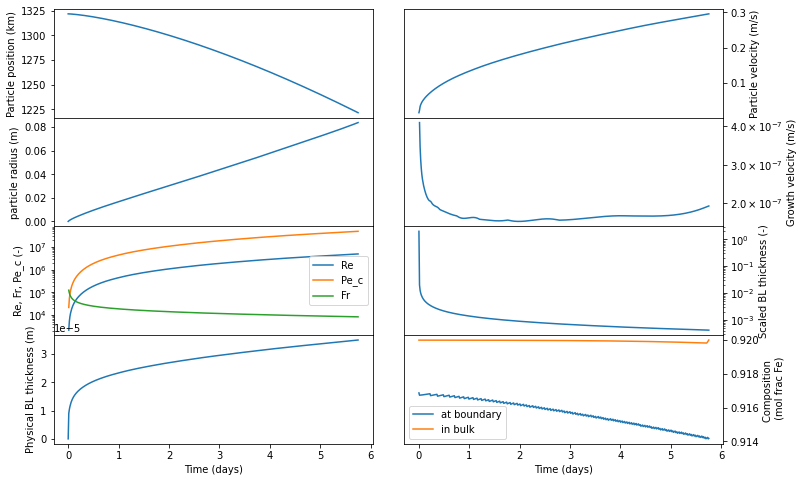


cases/1.000e-08_i0_case.pickle
growth rate 1491.8047512419712 km/Myr max vf_ratio 0.009132141225649447
Particle radii between 0.0267 and 9.07e-06 m


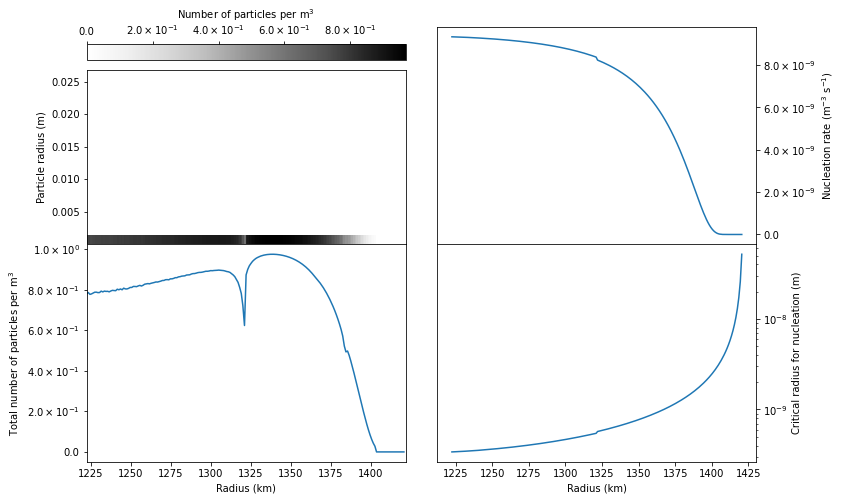

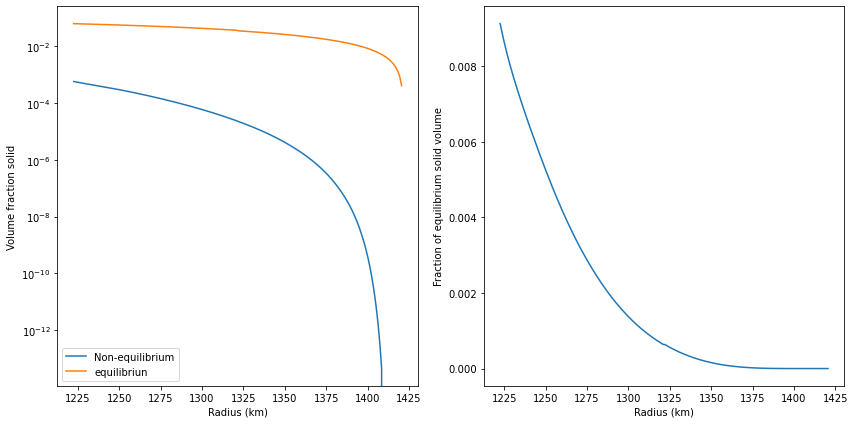

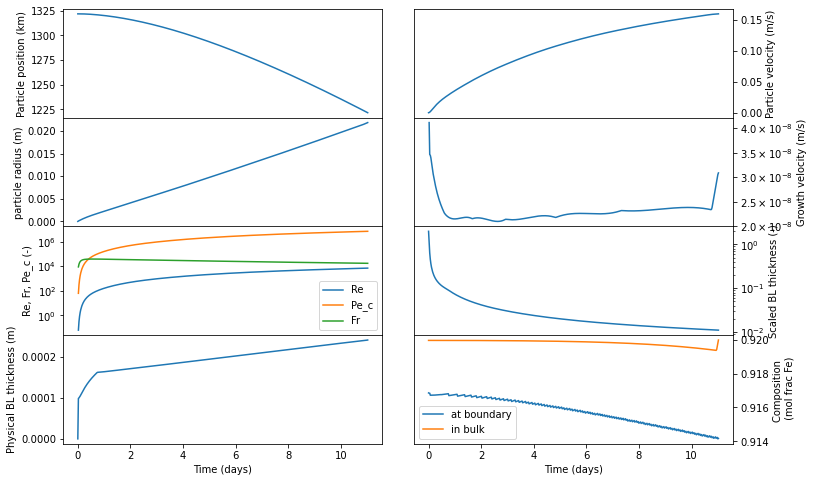


cases/1.000e+02_k0_case.pickle
growth rate 16.13940664005268 km/Myr max vf_ratio 9.811921694871155e-05
Particle radii between 0.0265 and 9.07e-06 m


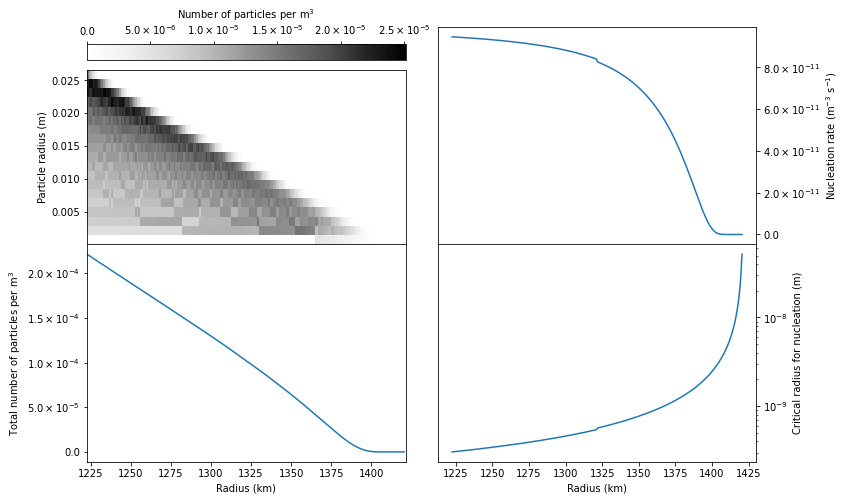

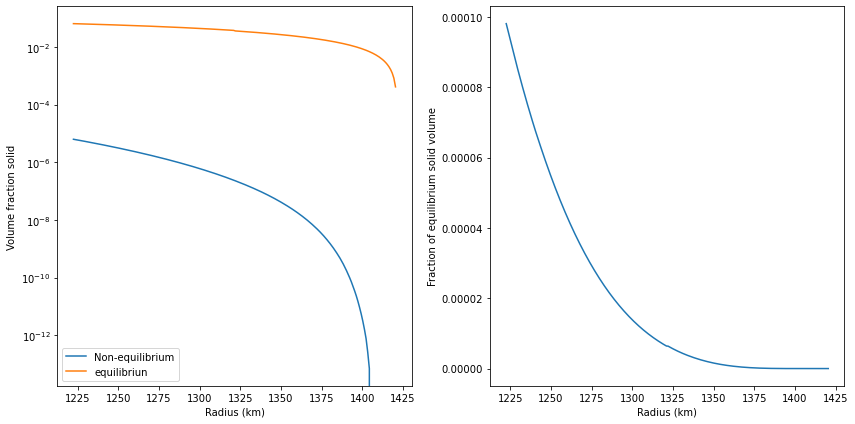

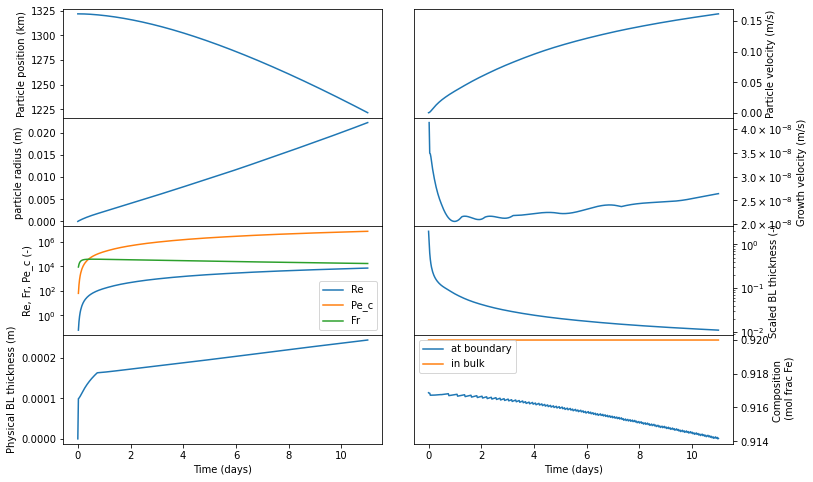


cases/1.000e-09_i0_case.pickle
growth rate 160.6650649809941 km/Myr max vf_ratio 0.00097872904013499
Particle radii between 0.0266 and 9.07e-06 m


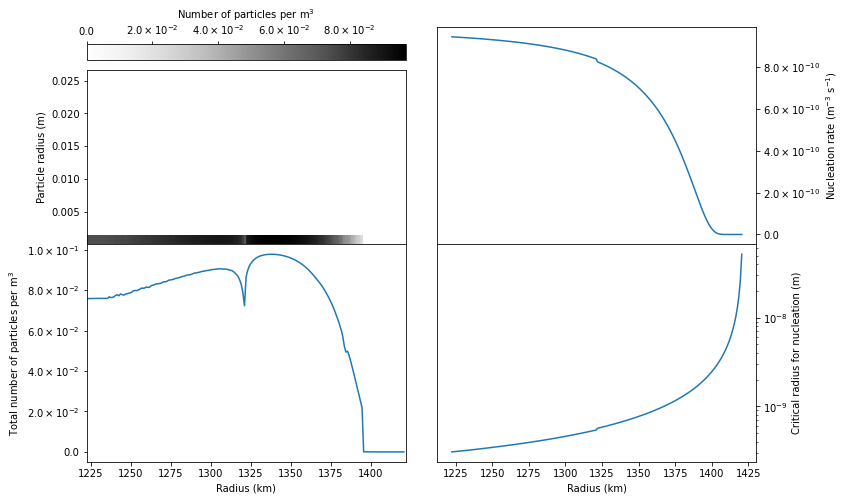

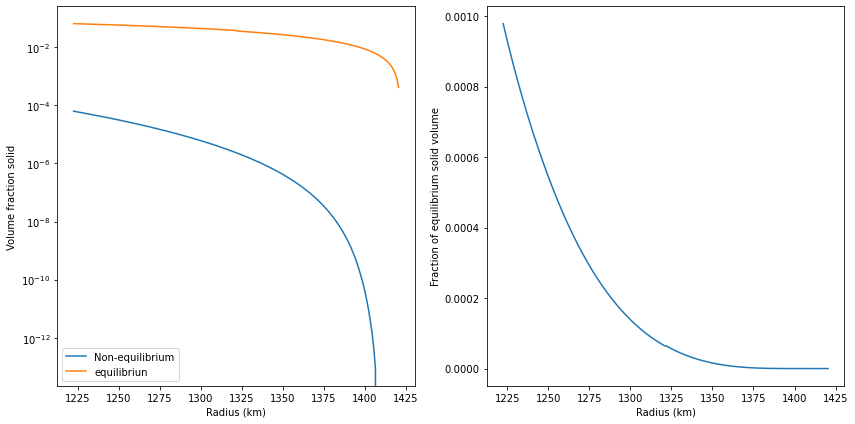

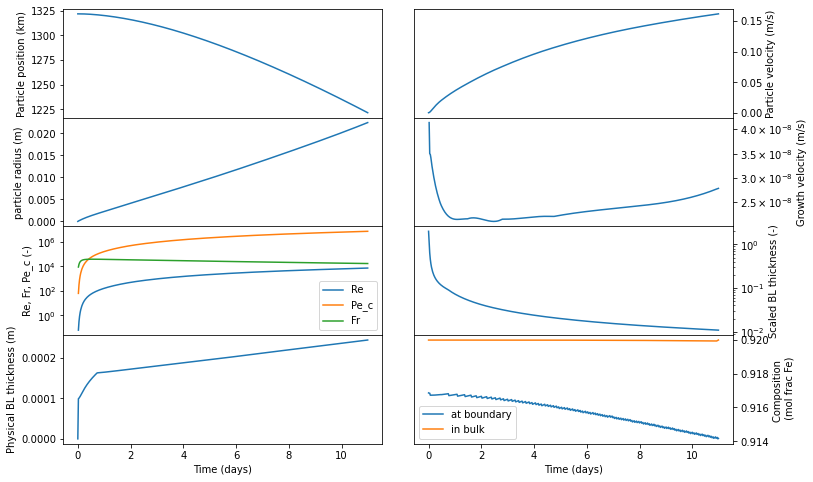


cases/base_case.pickle
growth rate 16.15632934419563 km/Myr max vf_ratio 9.820868684020741e-05
Particle radii between 0.0266 and 9.07e-06 m


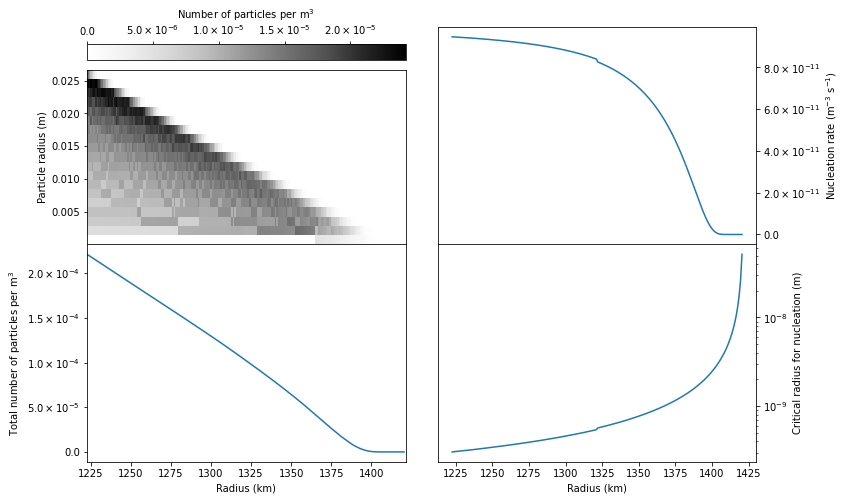

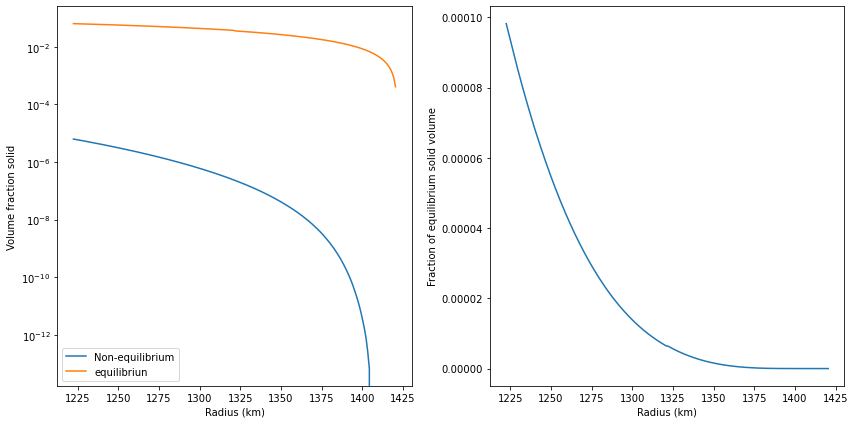

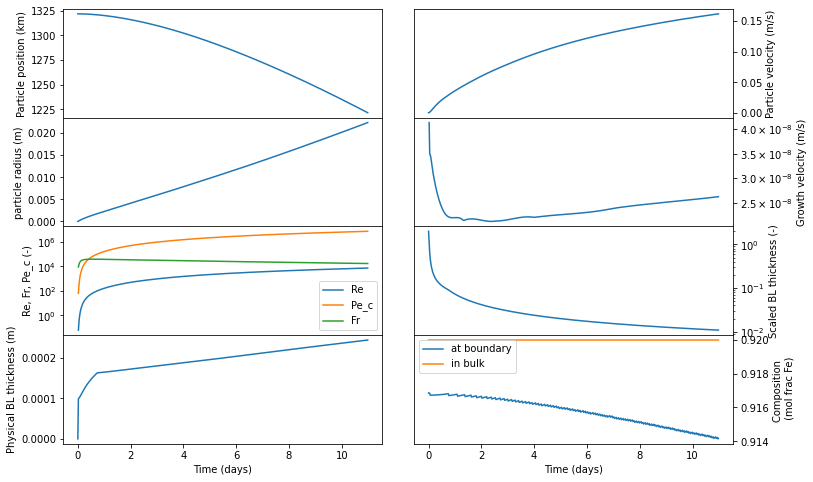


cases/5.000e-08_dl_case.pickle
growth rate 10801.239621263363 km/Myr max vf_ratio 0.02396667113319714
Particle radii between 0.245 and 2.4e-05 m


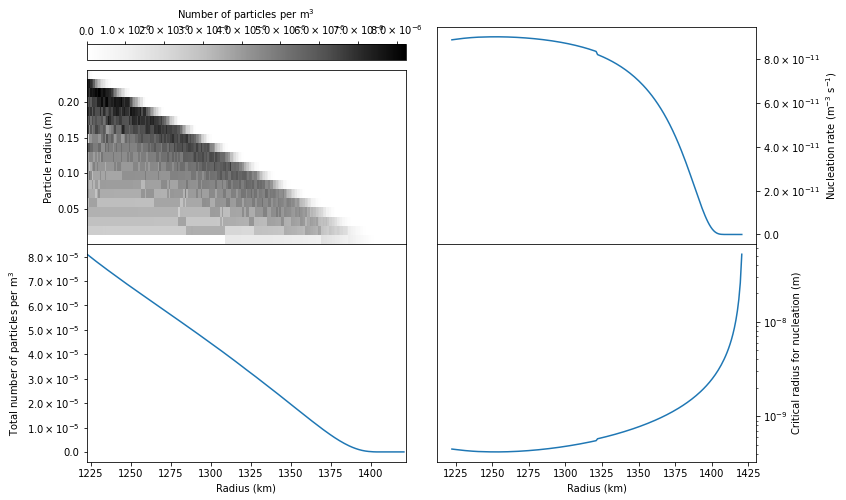

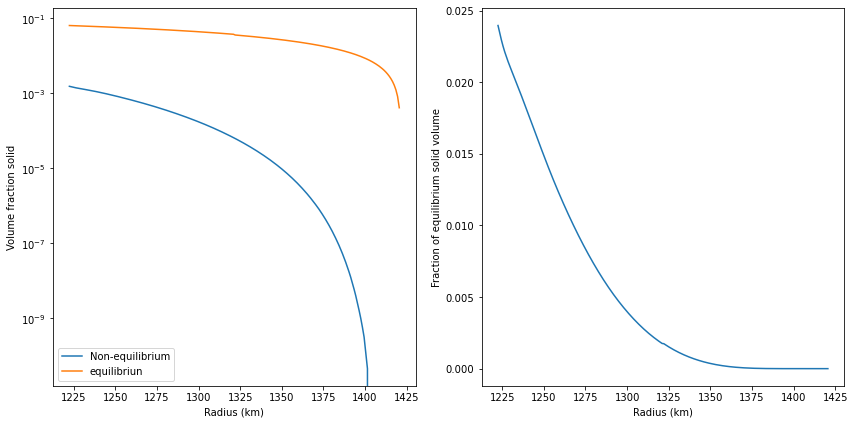

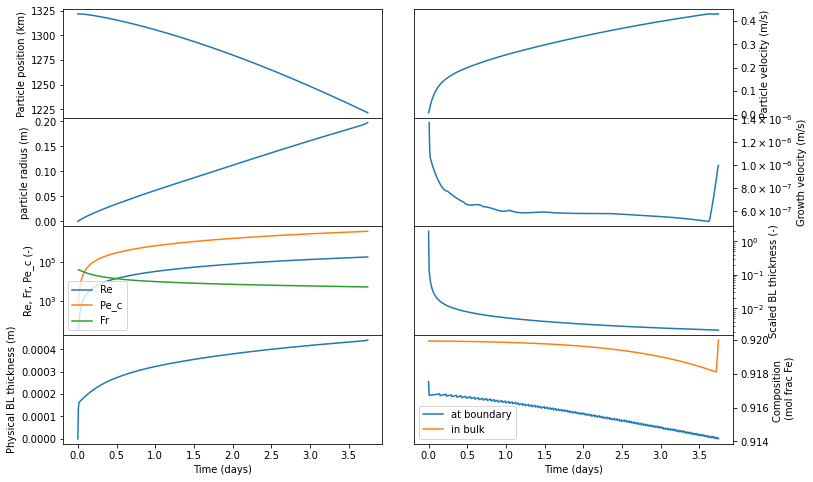


cases/1.080e-04_gamma_case.pickle
growth rate 0.00010469793216320427 km/Myr max vf_ratio 0.02395276615200848
Particle radii between 0.00429 and 9.07e-06 m


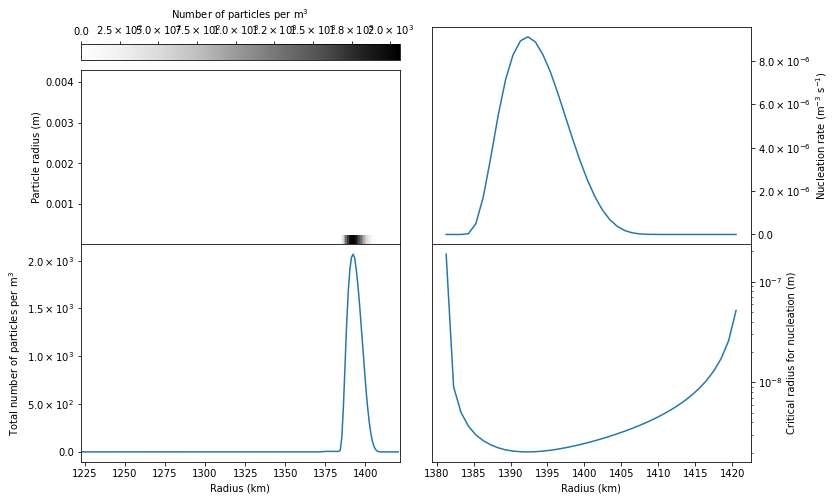

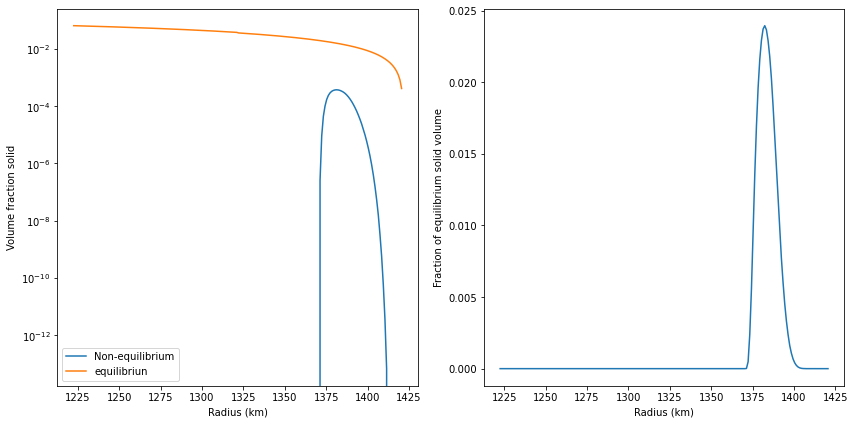

cases/2.000e+02_k0_case midpoint details failed! Exception was 'NoneType' object has no attribute 'sol'

cases/1.000e-08_dl_case.pickle
growth rate 847.8585400372062 km/Myr max vf_ratio 0.0029127242385376894
Particle radii between 0.101 and 1.61e-05 m


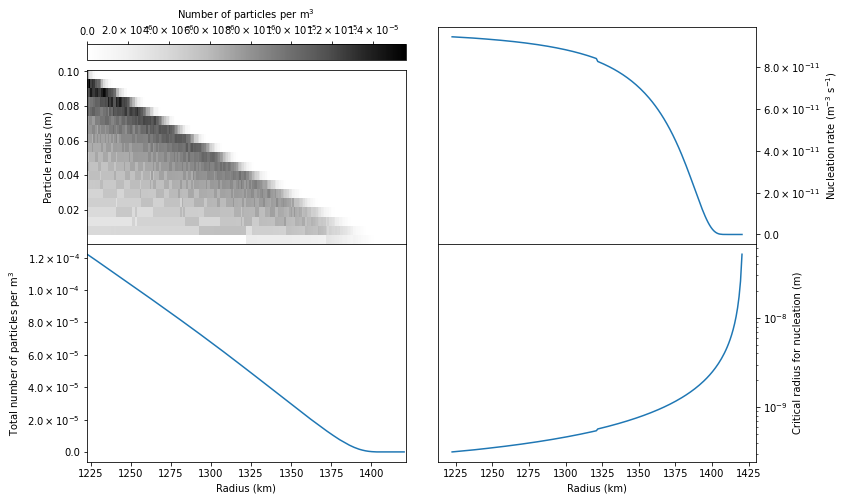

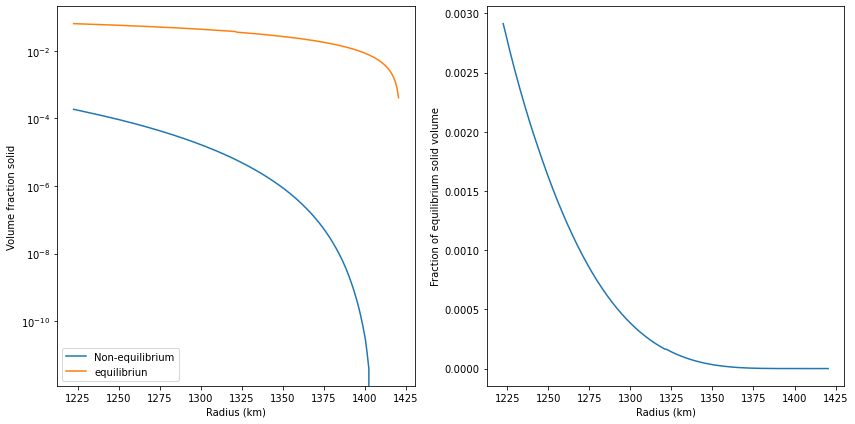

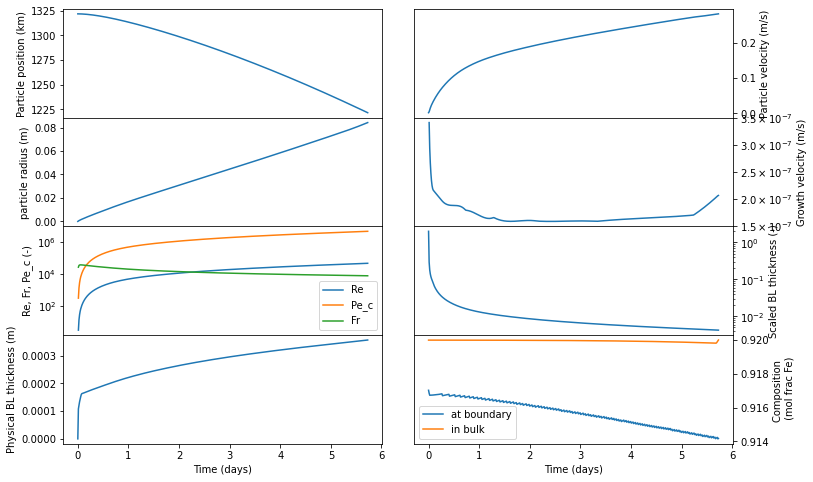


cases/5.000e-09_dl_case.pickle
growth rate 257.4899347621534 km/Myr max vf_ratio 0.0010606338932439123
Particle radii between 0.0674 and 1.36e-05 m


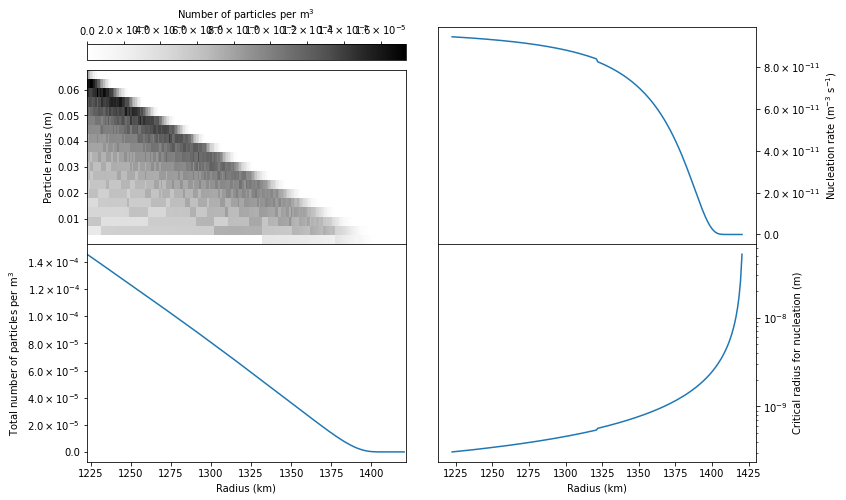

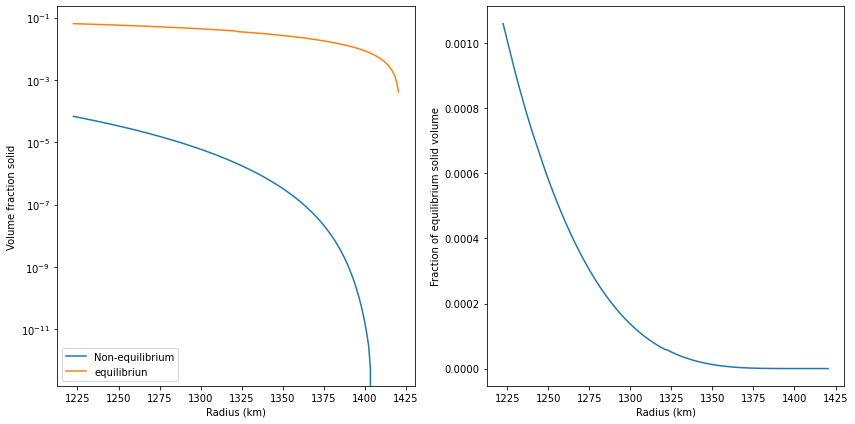

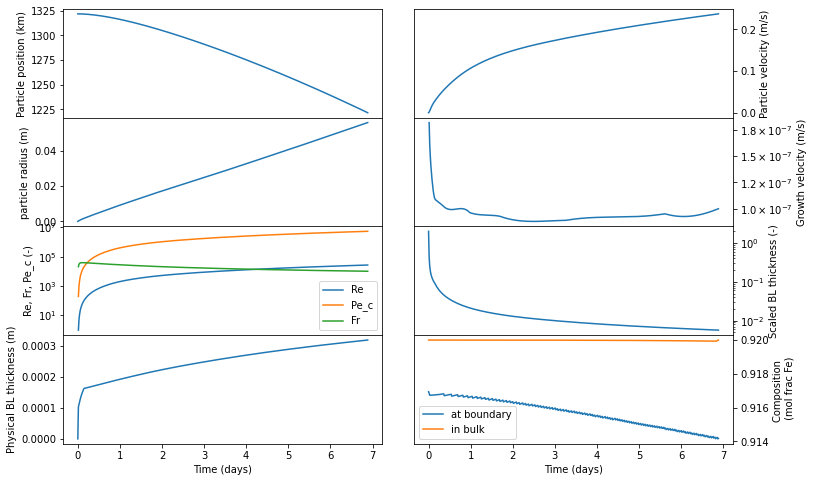


cases/1.000e-10_dl_case.pickle
growth rate 0.3868062019987663 km/Myr max vf_ratio 4.807150195448184e-06
Particle radii between 0.00754 and 5.09e-06 m


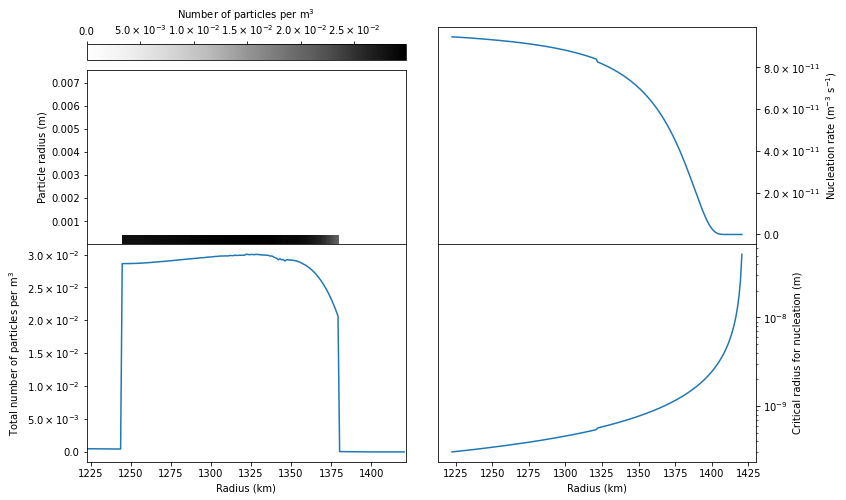

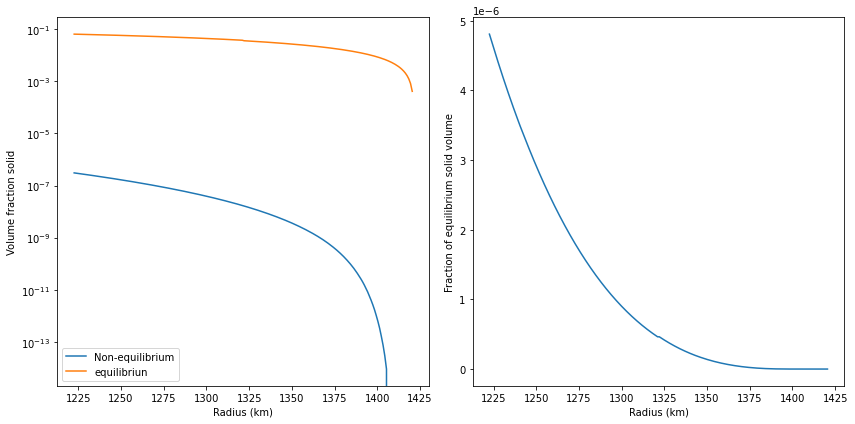

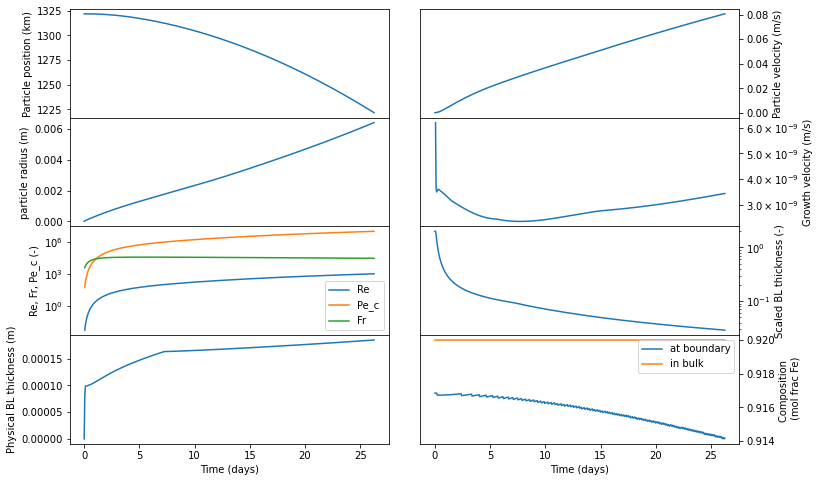


cases/1.080e-03_gamma_case.pickle
growth rate 0.0010458504623505843 km/Myr max vf_ratio 0.018480194022630247
Particle radii between 0.00314 and 9.07e-06 m


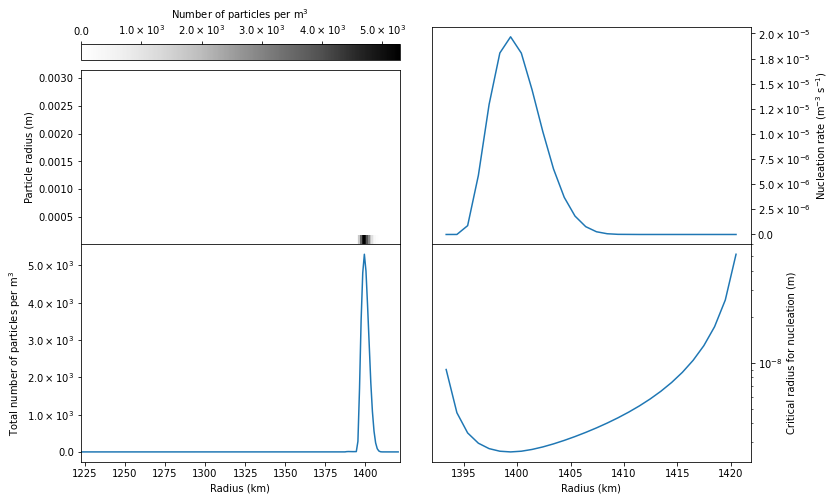

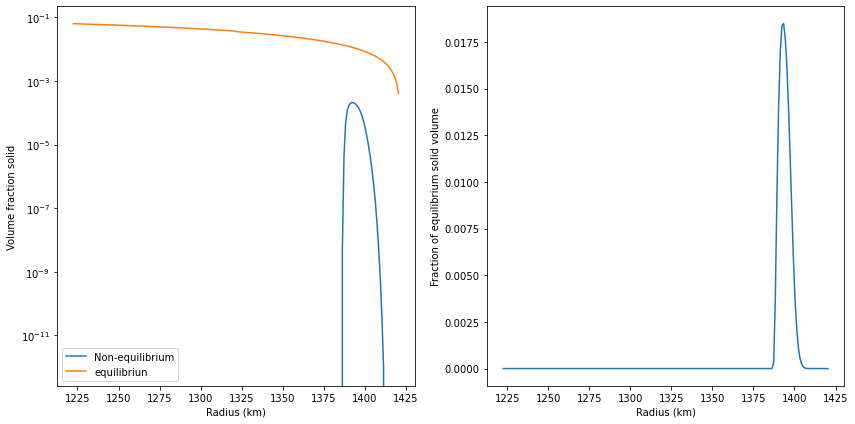

cases/2.000e+02_k0_case midpoint details failed! Exception was 'NoneType' object has no attribute 'sol'

cases/5.000e-11_dl_case.pickle
growth rate 0.13410629534648366 km/Myr max vf_ratio 2.1941504061743172e-06
Particle radii between 0.00527 and 4.28e-06 m


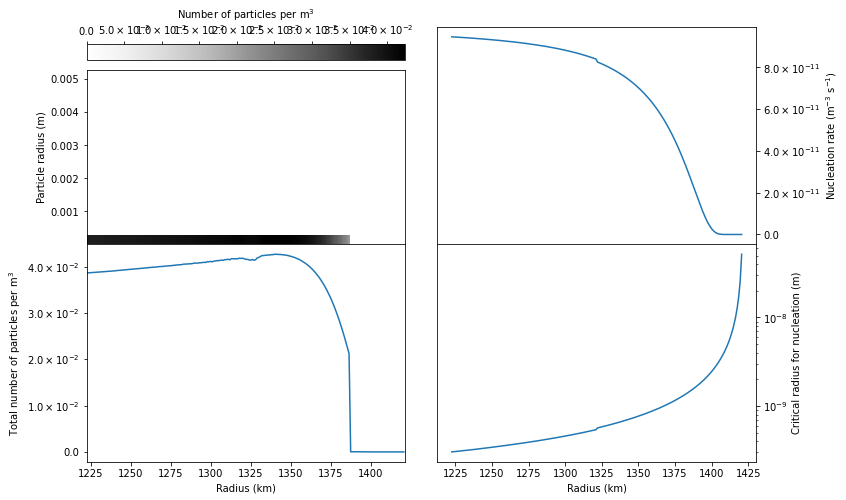

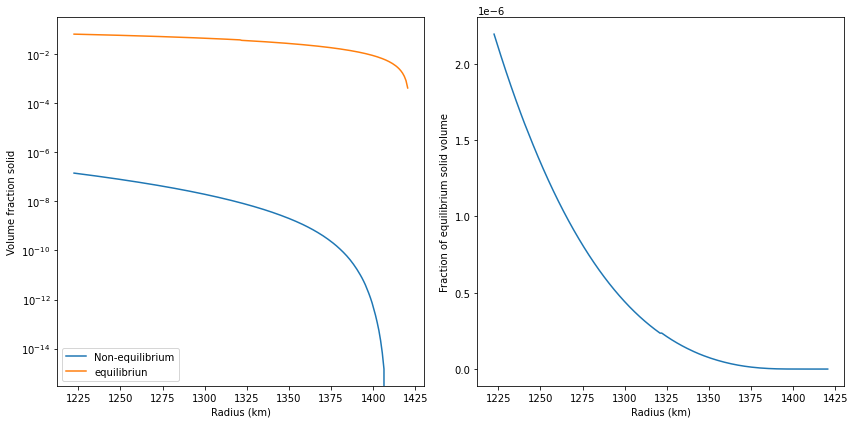

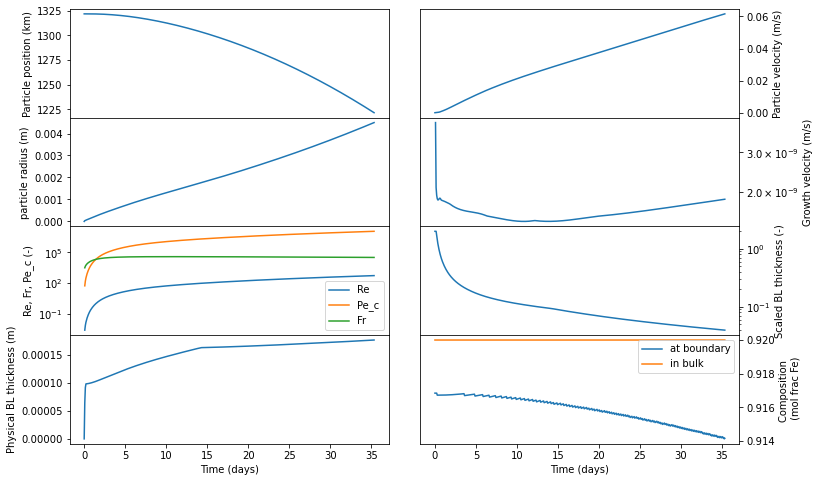


cases/5.000e-10_dl_case.pickle
growth rate 5.064651875265616 km/Myr max vf_ratio 3.688165735571022e-05
Particle radii between 0.0179 and 7.63e-06 m


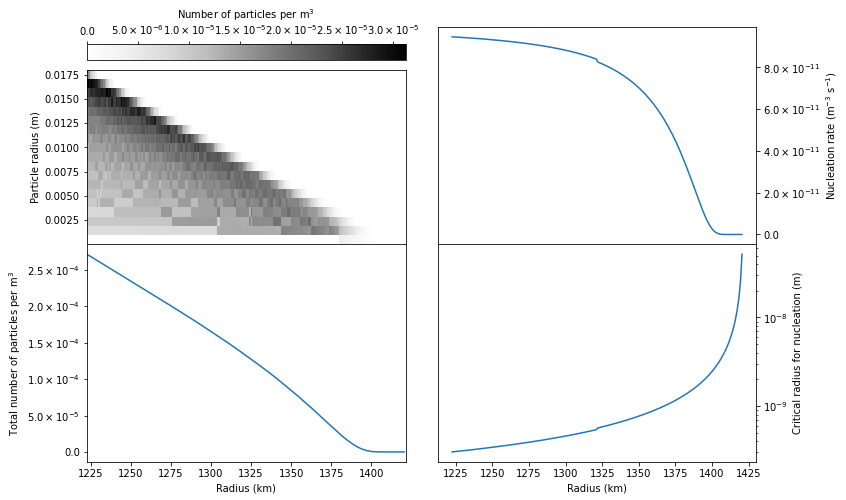

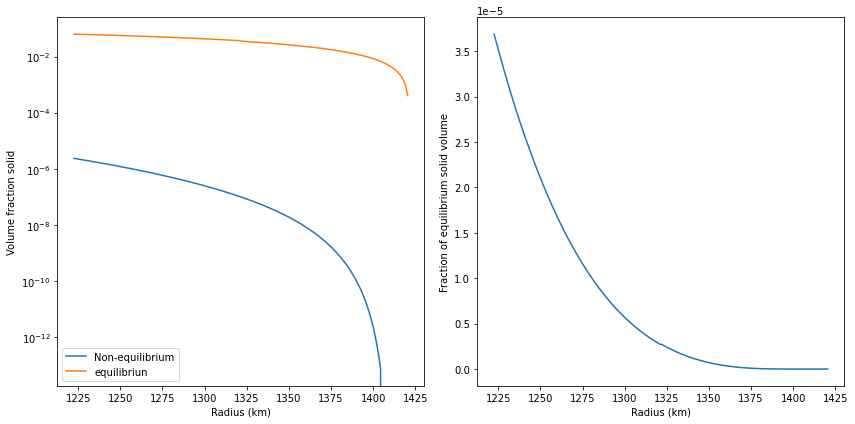

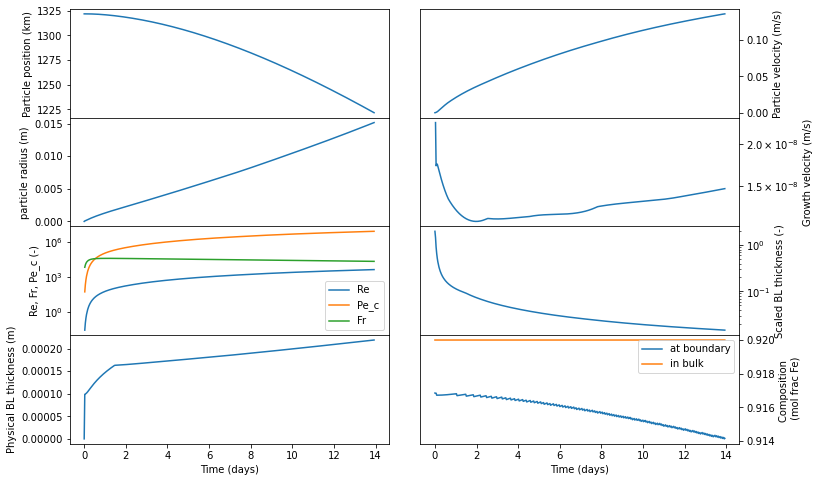

In [21]:
import glob

bulk_case_runner.plot_case_setup(**bulk_case_runner.load_case_data("cases/base_case.pickle"))

for file in glob.glob("cases/*.pickle"):
    print(file)
    data_from_file = bulk_case_runner.load_case_data(file)
    print(f"growth rate {data_from_file['growth_rate']} km/Myr max vf_ratio {data_from_file['vf_ratio'].max()}")
    # Crystal density and nucleation
    bulk_case_runner.plot_case_csd_nuc(**data_from_file)
    bulk_case_runner.plot_case_solid_frac(**data_from_file)
    # Plot P-T-R for reference. This is slow
    # Plot solution from 'middle' of layer
    try:
        bulk_case_runner.plot_case_single_solution(100, data_from_file)
    except Exception as err:
        print(f"{name} midpoint details failed! Exception was {err}")
    print()